In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
%matplotlib inline

/Users/stef/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/stef/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [154]:
##Load data for final model
data = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')

In [155]:
##Clean data by dropping extraneous columns
cleaned_data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Second stage of cleaning by removing na values from dataframe
cleaned_data = cleaned_data.dropna()

In [156]:
##Create gender dummy variables for model
gender_dummies = pd.get_dummies(cleaned_data.gender, prefix='gender')
cleaned_data = cleaned_data.join(gender_dummies)

In [157]:
##Consolidate all starts (code DNF with finishers) for modeling
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
print 'Before Coding:'
print pd.value_counts(cleaned_data["status"])
cleaned_data["status_coded"] = coding(cleaned_data["status"], {'1':0,'2':0, '3':1})
cleaned_data['DNF_DNS_coded'] = coding(cleaned_data["status"], {'1':1,'2':0, '3':0})
print '\nAfter Coding:'
print pd.value_counts(cleaned_data["status_coded"])
print '\nAfter DNF Coding:'
print pd.value_counts(cleaned_data["DNF_DNS_coded"])
status_coded = cleaned_data.drop(['status'], axis=1)
status_DNF = cleaned_data.copy()
status_DNF = cleaned_data.drop(['status', 'status_coded'], axis=1)

Before Coding:
1    6203
2    3809
3     498
Name: status, dtype: int64

After Coding:
0    10012
1      498
Name: status_coded, dtype: int64

After DNF Coding:
1    6203
0    4307
Name: DNF_DNS_coded, dtype: int64


In [158]:
status_coded.head()

,age,gender,participant_id,runner_rank,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F,gender_M,status_coded,DNF_DNS_coded
0,26,M,7148,88.39,11470,Bear,3,0,1,1,2.5,0.7174,0.6806,23.0,0.956522,0.0,1.0,0,1
1,33,M,221721,90.00,11470,Bear,3,0,1,1,2.5,0.8132,0.6987,9.0,0.888889,0.0,1.0,0,1
2,43,M,20020,83.63,11470,Bear,3,0,1,1,2.5,0.8272,0.7145,17.0,0.882353,0.0,1.0,0,1
3,36,M,25441,73.22,11470,Bear,3,0,1,1,2.5,0.8995,0.8957,18.0,0.800000,0.0,1.0,0,1
4,33,M,22562,87.77,11470,Bear,3,0,1,1,2.5,0.6807,0.6522,8.0,1.000000,0.0,1.0,0,1


In [159]:
##Set response variable for coded dataframe
y_DNS = status_coded.pop('status_coded')
##Set response variable for uncoded dataframe
y_DNF = cleaned_data.pop('status')
##Set response variable for DNF/DNS to finishers DF
y_Finish = cleaned_data.pop('DNF_DNS_coded')

In [163]:
##Set predictors for coded dataframe
codedX = status_coded.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', \
                  'Gender_Rank', 'Total_races'\
                 , 'gender_M'], axis=1)
##Set predictors for uncoded dataframe
uncodedX = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', \
                  'Gender_Rank', 'Total_races'\
                 , 'gender_M', 'status_coded'], axis=1)
##Set predictors for predicting DNF/DNS to finishers
finish_model = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', \
                  'Gender_Rank', 'Total_races'\
                 , 'gender_M', 'status_coded'], axis=1)

In [165]:
##Create test/train splits for both datasets
##coded dataframe
cX_train, cX_test, cy_train, cy_test = train_test_split(codedX, y_DNS, test_size=0.3)
##uncoded dataframe
uX_train, uX_test, uy_train, uy_test = train_test_split(uncodedX, y_DNF, test_size=0.3)
##finisher dataframe
fX_train, fX_test, fy_train, fy_test = train_test_split(finish_model, y_Finish, test_size=0.3)

# Logistic Regression Modeling

In [142]:
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRp = cLR.predict_proba(cX_test)
cLRpr = cLR.predict(cX_test)
print log_loss(cy_test, cLRp)
print roc_auc_score(cy_test, cLRp[:,1])
print confusion_matrix(cy_test, cLRpr)

0.188198222998
0.572145523227
[[3005    0]
 [ 148    0]]


In [143]:
##uncoded dataframe
uLR = LR(C=10)
uLR.fit(uX_train, uy_train)
uLRp = uLR.predict_proba(uX_test)
uLRa = uLR.predict(uX_test)
print log_loss(uy_test, uLRp)
print accuracy_score(uy_test, uLRa)

0.770878684994
0.634950840469


In [170]:
##Finisher dataframe
fLR = LR(C=10)
fLR.fit(fX_train, fy_train)
fLRp = fLR.predict_proba(fX_test)
fLRpr = fLR.predict(fX_test)
print log_loss(fy_test, fLRp)
print roc_auc_score(fy_test, fLRp[:,1])
#print confusion_matrix(cy_test, cLRpr)

0.640018107474
0.64637116486


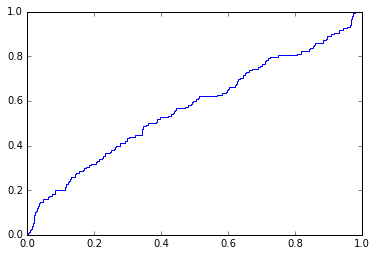

0.060757423817388946

In [144]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
plt.plot(fpr, tpr)
plt.show()
thresholds.mean()

# Random Forest

In [145]:
##coded dataframe
cRF = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
cRF.fit(cX_train, cy_train)
cRFp = cRF.predict_proba(cX_test)
cRFpr = cRF.predict(cX_test)

print log_loss(cy_test, cRFp)
print roc_auc_score(cy_test, cRFp[:,1])
print confusion_matrix(cy_test, cRFpr)

0.387993102188
0.659900166389
[[2990   15]
 [ 145    3]]


In [146]:
positive = []
negative = []
for each in cRFp[:,1]:
    if each > 0.002:
        positive.append(1)
        negative.append(0)
    else:
        positive.append(0)
        negative.append(1)
confusion_matrix(cy_test, negative)   

array([[2025,  980],
       [ 120,   28]])

In [147]:
##uncoded dataframe
uRF = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
uRF.fit(uX_train, uy_train)
uRFp = uRF.predict_proba(uX_test)
uRFa = uRF.predict(uX_test)
print log_loss(uy_test, uRFp)
print accuracy_score(uy_test, uRFa)
print confusion_matrix(uy_test, uRFa)

0.925412995828
0.63177925785
[[1458  397   17]
 [ 587  529   16]
 [ 108   36    5]]


In [175]:
fX_train.head()

,age,runner_rank,Season,Metro_area,WL_SO,Entry_fee,PPM,Success_rate,gender_F
7886,57,74.84,2,1,1,1,4.10,0.000000,0.0
8020,54,60.70,2,1,1,1,4.10,1.000000,0.0
9888,37,78.35,3,0,1,1,2.50,0.666667,1.0
906,29,72.81,3,0,1,1,2.50,0.875000,0.0
3975,28,67.71,3,1,0,1,2.65,1.000000,0.0


In [176]:
##Finisher dataframe
fRF = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
fRF.fit(fX_train, fy_train)
fRFp = fRF.predict_proba(fX_test)
fRFpr = fRF.predict(fX_test)

print log_loss(fy_test, fRFp)
print roc_auc_score(fy_test, fRFp[:,1])
print confusion_matrix(fy_test, fRFpr)

0.674482706743
0.673314478781
[[ 656  631]
 [ 478 1388]]


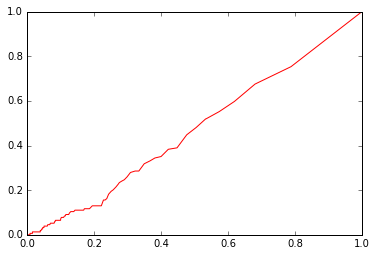

In [177]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')


# Gradient Boosted Classifier

In [149]:
##coded dataframe
cGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
cGBC.fit(cX_train, cy_train)
cGBCp = cGBC.predict_proba(cX_test)
cGBCpr = cGBC.predict(cX_test)
print log_loss(cy_test, cGBCp)
print roc_auc_score(cy_test, cGBCp[:,1])
print confusion_matrix(cy_test, cGBCpr)

0.183594737652
0.666899761658
[[3000    5]
 [ 148    0]]


In [150]:
##uncoded dataframe
uGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
uGBC.fit(uX_train, uy_train)
uGBCp = uGBC.predict_proba(uX_test)
uGBCa = uGBC.predict(uX_test)
print log_loss(uy_test, uGBCp)
print accuracy_score(uy_test, uGBCa)

0.752728513647
0.640025372661


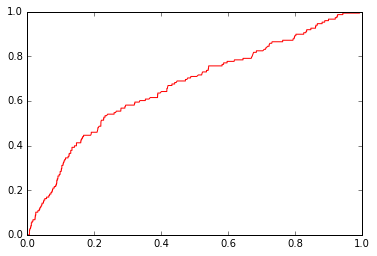

In [151]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
plt.show()

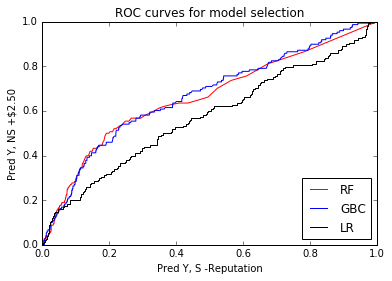

In [152]:
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('Pred Y, NS +$2.50')
plt.xlabel('Pred Y, S -Reputation')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

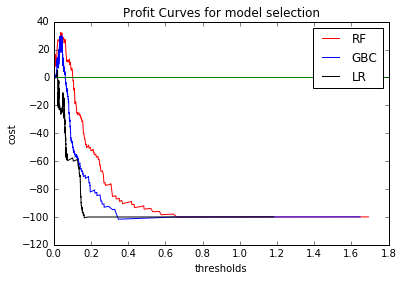

In [153]:
TPC = 250.
FPC = -250.
FNC = -100.
TNC = 0.
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
RFP = plt.plot(thresholds, cost, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1])
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
GBcost = plt.plot(thresholds, cost, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
LRP = plt.plot(thresholds, cost, 'k', label='Logistic Regression')
plt.axhline(0, color='g')
plt.ylabel('cost')
plt.xlabel('thresholds')
plt.title('Profit Curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=1)
plt.show()